In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Sử dụng seed để tạo tính ổn định của mô hình. Nó được sử dụng để đảm bảo rằng mọi số ngẫu nhiên sinh ra trong quá trình huấn luyện đều có thể tái tạo lại và giống nhau ở mỗi lần chạy, giúp quá trình huấn luyện mô hình trở nên ổn định, dễ dàng so sánh và kiểm tra lại kết quả. 

In [2]:
# Configure parameters
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G
image_size = 8  
batch_size = 1
lrG = 0.003  # Learning rate for the generator
lrD = 0.001  # Learning rate for the discriminator
num_iter = 50  # Number of training iterations

In [3]:
# Dowload data
class DigitsDataset(Dataset):
    def __init__(self, csv_file, label=0, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image).astype(np.float32).reshape(8, 8)
        if self.transform:
            image = self.transform(image)
        return image, 0


# Create DataLoader
dataset = DigitsDataset(csv_file="D:/4. MACHINE LEARNING/GAN/data_qgans/optdigits.tra")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


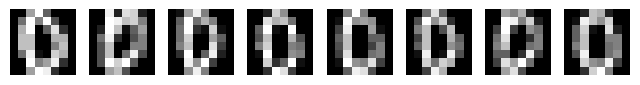

In [4]:
# Display some sample images
plt.figure(figsize=(8, 2))
for i in range(8):
    image = dataset[i][0]
    plt.subplot(1, 8, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()

In [5]:
class QuantumGenerator:
    def __init__(self, n_qubits, q_depth, n_generators, q_delta=1.0):
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.n_generators = n_generators
        self.q_params = [
            np.random.uniform(-q_delta, q_delta, (q_depth, n_qubits))
            for _ in range(n_generators)
        ]
        self.simulator = AerSimulator()

    def quantum_circuit(self, noise, weights):
        circuit = QuantumCircuit(self.n_qubits)
        # Apply RY gates to noise
        # State Embedding
        for i in range(self.n_qubits):
            # RY gate
            circuit.ry(float(noise[i]), i)
        circuit.barrier()
        # Parameterised layers 
        for layer in weights:
            for i, theta in enumerate(layer):
                # RY gate
                circuit.ry(float(theta), i)
            for i in range(self.n_qubits - 1):
                # Control Z gates
                circuit.cz(i, i + 1)
            circuit.barrier()
        # Measure all qubits
        circuit.measure_all()
        return circuit

    def partial_measure(self, noise, weights):
        circuit = self.quantum_circuit(noise, weights)
        # Execute the circuit 1024 times
        job = self.simulator.run(circuit, shots=1024)
        result = job.result()
        counts = result.get_counts(circuit)

        # Calculate probability 
        probs = np.array([counts.get(format(i, f'0{self.n_qubits}b'), 0) for i in range(2 ** self.n_qubits)])
        probs = probs / np.sum(probs)

        # Non-linear Transform
        probsgiven0 = probs[: 2 ** (self.n_qubits - n_a_qubits)]
        probsgiven0 = probsgiven0 / np.sum(probsgiven0)

        # Post-Processing
        return probsgiven0 / np.max(probsgiven0)

    def generate(self, noise_batch):
        patch_size = 2 ** (self.n_qubits - n_a_qubits)
        generated_images = []

        for noise in noise_batch:
            patches = []
            for weights in self.q_params:
                patch = self.partial_measure(noise, weights)
                patches.append(patch)
            generated_image = np.hstack(patches)
            generated_images.append(generated_image)

        return np.array(generated_images)

    # Update_params
    def update_params(self, gradients, learning_rate):
        for i in range(len(self.q_params)):
            self.q_params[i] -= learning_rate * gradients[i]

In [6]:
# Implementing the discriminator 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [7]:
# Initialize generator and discriminator
generator = QuantumGenerator(n_qubits, q_depth, n_generators)
discriminator = Discriminator().to(torch.device("cpu"))

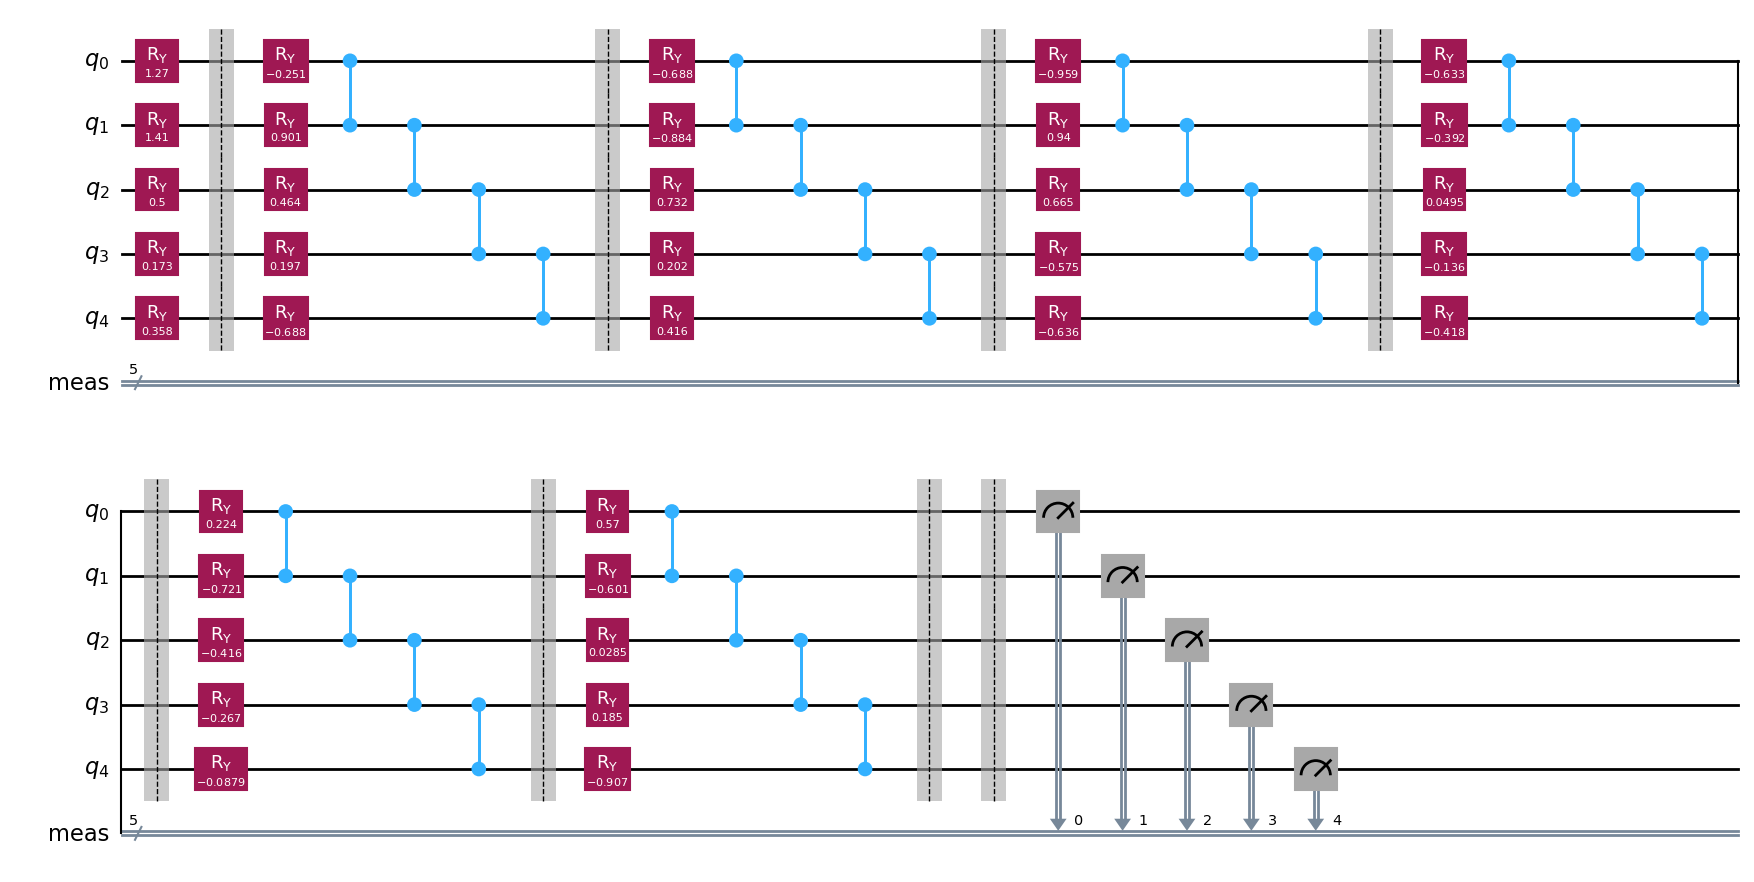

In [8]:
# Quantum circuit
noise_sample = np.random.uniform(0, np.pi / 2, (n_qubits,))  
weights_sample = generator.q_params[0]  
quantum_circuit = generator.quantum_circuit(noise_sample, weights_sample)  
quantum_circuit.draw('mpl')

In [9]:
# Training 
criterion = nn.BCELoss()
optD = optim.SGD(discriminator.parameters(), lr=lrD)
generator_losses = []
discriminator_losses = []

for epoch in range(num_iter):
    for i, (data, _) in enumerate(dataloader):
        # Real data
        real_data = data.reshape(-1, image_size * image_size).numpy()

        # Generate fake data
        noise = np.random.uniform(0, np.pi / 2, (batch_size, n_qubits))
        fake_data = generator.generate(noise)

        # Discriminator training
        discriminator.zero_grad()
        real_output = discriminator(torch.tensor(real_data, dtype=torch.float32)).view(-1)
        fake_output = discriminator(torch.tensor(fake_data, dtype=torch.float32)).view(-1)

        real_labels = torch.ones_like(real_output)
        fake_labels = torch.zeros_like(fake_output)

        errD_real = criterion(real_output, real_labels)
        errD_fake = criterion(fake_output, fake_labels)
        errD = errD_real + errD_fake
        errD.backward()
        optD.step()

        discriminator_losses.append(errD.item())

        # Generator training
        fake_data = generator.generate(noise)
        fake_output = discriminator(torch.tensor(fake_data, dtype=torch.float32)).view(-1)
        
        gen_labels = torch.ones_like(fake_output)
        errG = criterion(fake_output, gen_labels)
        
        # Calculate gradient 
        gradients = [np.random.uniform(-0.1, 0.1, params.shape) for params in generator.q_params] 
        # Update generator parameters
        generator.update_params(gradients, lrG)
        generator_losses.append(errG.item())

    # Show results
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_iter}, Discriminator Loss: {errD.item():.5f}, Generator Loss: {errG.item():.5f}")

Epoch 0/50, Discriminator Loss: 1.32539, Generator Loss: 0.61218
Epoch 10/50, Discriminator Loss: 0.03242, Generator Loss: 3.97127
Epoch 20/50, Discriminator Loss: 0.01000, Generator Loss: 5.21233
Epoch 30/50, Discriminator Loss: 0.00303, Generator Loss: 6.45626
Epoch 40/50, Discriminator Loss: 0.00190, Generator Loss: 6.26590


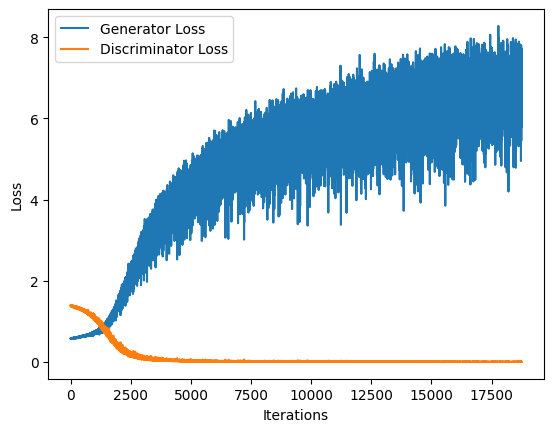

In [10]:
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 10/50


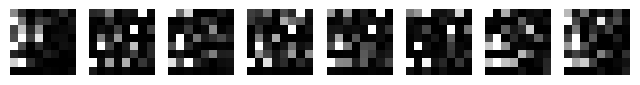

Epoch 20/50


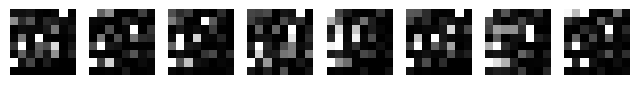

Epoch 30/50


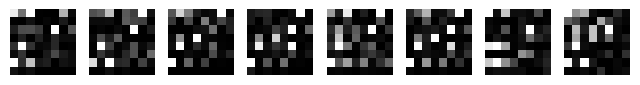

Epoch 40/50


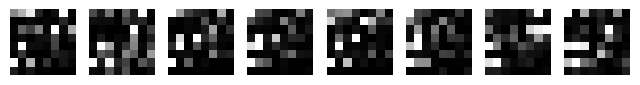

Epoch 50/50


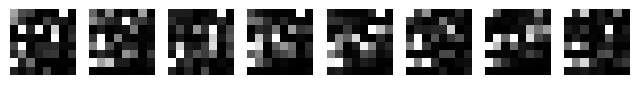

In [11]:
for epoch in range (1,num_iter+1):
    if epoch % 10 == 0:    
        print(f"Epoch {epoch}/{num_iter}")
        fixed_noise = np.random.uniform(0, np.pi / 2, (8, n_qubits)) 
        generated_images = generator.generate(fixed_noise)  # Generate image from generator
        num_images_to_show = 8  
        plt.figure(figsize=(8, 2)) 
        for i in range(num_images_to_show):
            plt.subplot(1, 8, i + 1)
            plt.imshow(generated_images[i].reshape(image_size, image_size), cmap="gray")
            plt.axis("off")   
        plt.show()

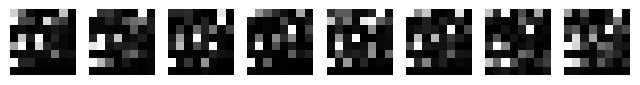

In [12]:
fixed_noise = np.random.uniform(0, np.pi / 2, (8, n_qubits))
generated_images = generator.generate(fixed_noise)
plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(generated_images[i].reshape(image_size, image_size), cmap="gray")
    plt.axis("off")
plt.show()
